In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error


import warnings
warnings.filterwarnings("ignore")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [14]:
data_path = "/kaggle/input/manipal-atmospherics/manipal_atmospherics_df.csv"

df = pd.read_csv(
    data_path,
    skiprows=2   # <-- CRITICAL FIX
)

print("Shape:", df.shape)
df.head()


Shape: (5480, 13)


,time,temperature_2m_mean (°C),precipitation_sum (mm),shortwave_radiation_sum (MJ/m²),apparent_temperature_mean (°C),wind_speed_10m_max (km/h),et0_fao_evapotranspiration (mm),sunshine_duration (s),wind_direction_10m_dominant (°),pressure_msl_mean (hPa),cloud_cover_mean (%),dew_point_2m_mean (°C),soil_moisture_0_to_7cm_mean (m³/m³)
0,2011-01-04,24.7,0.0,19.69,27.7,17.4,4.09,36798.94,325,1009.7,70,20.4,0.278
1,2011-01-05,25.4,0.0,17.77,28.5,15.9,3.91,36494.80,309,1008.7,85,20.4,0.276
2,2011-01-06,26.2,0.0,19.31,28.8,18.4,4.45,36924.74,319,1008.7,61,19.4,0.273
3,2011-01-07,25.6,0.0,20.26,28.0,15.6,4.52,37417.72,178,1008.6,12,18.6,0.270
4,2011-01-08,25.2,0.0,20.29,28.2,15.1,4.38,37473.21,313,1008.3,29,20.0,0.268


In [15]:
# Rename columns to ML-friendly names
df = df.rename(columns={
    'time': 'date',
    'temperature_2m_mean (°C)': 'temperature_2m_mean',
    'precipitation_sum (mm)': 'precipitation_sum',
    'shortwave_radiation_sum (MJ/m²)': 'shortwave_radiation_sum',
    'apparent_temperature_mean (°C)': 'apparent_temperature_mean',
    'wind_speed_10m_max (km/h)': 'wind_speed_10m_max',
    'et0_fao_evapotranspiration (mm)': 'et0_fao_evapotranspiration',
    'sunshine_duration (s)': 'sunshine_duration',
    'wind_direction_10m_dominant (°)': 'wind_direction_10m_dominant',
    'pressure_msl_mean (hPa)': 'pressure_msl_mean',
    'cloud_cover_mean (%)': 'cloud_cover_mean',
    'dew_point_2m_mean (°C)': 'dew_point_2m_mean',
    'soil_moisture_0_to_7cm_mean (m³/m³)': 'soil_moisture_0_to_7cm_mean'
})

# Convert date column
df['date'] = pd.to_datetime(df['date'])

# Sort chronologically
df = df.sort_values('date').reset_index(drop=True)

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5480 entries, 0 to 5479
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   date                         5480 non-null   datetime64[ns]
 1   temperature_2m_mean          5480 non-null   float64       
 2   precipitation_sum            5480 non-null   float64       
 3   shortwave_radiation_sum      5480 non-null   float64       
 4   apparent_temperature_mean    5480 non-null   float64       
 5   wind_speed_10m_max           5480 non-null   float64       
 6   et0_fao_evapotranspiration   5480 non-null   float64       
 7   sunshine_duration            5480 non-null   float64       
 8   wind_direction_10m_dominant  5480 non-null   int64         
 9   pressure_msl_mean            5480 non-null   float64       
 10  cloud_cover_mean             5480 non-null   int64         
 11  dew_point_2m_mean            5480 non-null 

In [16]:
df.isna().sum()
# Forward fill (safe for time-series)
df = df.fillna(method='ffill')


In [17]:
train_df = df[df['date'] < '2023-01-01']
val_df   = df[(df['date'] >= '2023-01-01') & (df['date'] < '2025-01-04')]
test_df  = df[(df['date'] >= '2025-01-04') & (df['date'] <= '2026-01-04')]

print("Train:", len(train_df))
print("Validation:", len(val_df))
print("Test:", len(test_df))


Train: 4380
Validation: 734
Test: 366


In [18]:
features = [
    'temperature_2m_mean',
    'precipitation_sum',
    'shortwave_radiation_sum',
    'apparent_temperature_mean',
    'wind_speed_10m_max',
    'et0_fao_evapotranspiration',
    'sunshine_duration',
    'pressure_msl_mean',
    'cloud_cover_mean',
    'dew_point_2m_mean',
    'soil_moisture_0_to_7cm_mean'
]

target_temp = 'temperature_2m_mean'
target_prec = 'precipitation_sum'

scaler = StandardScaler()
scaler.fit(train_df[features])

train_scaled = scaler.transform(train_df[features])
val_scaled   = scaler.transform(val_df[features])
test_scaled  = scaler.transform(test_df[features])


In [19]:
class TimeSeriesDataset(torch.utils.data.Dataset):
    def __init__(self, data, target_idx, window=30):
        self.X, self.y = [], []
        for i in range(len(data) - window):
            self.X.append(data[i:i+window])
            self.y.append(data[i+window, target_idx])

        self.X = torch.tensor(self.X, dtype=torch.float32)
        self.y = torch.tensor(self.y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [20]:
WINDOW = 30
BATCH_SIZE = 32

temp_idx = features.index(target_temp)
prec_idx = features.index(target_prec)

train_ds_temp = TimeSeriesDataset(train_scaled, temp_idx, WINDOW)
val_ds_temp   = TimeSeriesDataset(val_scaled, temp_idx, WINDOW)
test_ds_temp  = TimeSeriesDataset(test_scaled, temp_idx, WINDOW)

train_loader = DataLoader(train_ds_temp, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds_temp, batch_size=BATCH_SIZE, shuffle=False)


In [21]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super().__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        _, h = self.rnn(x)
        return self.fc(h[-1])


class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super().__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        _, h = self.gru(x)
        return self.fc(h[-1])


class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        _, (h, _) = self.lstm(x)
        return self.fc(h[-1])


In [22]:
def train_model(model, train_loader, val_loader, epochs=25):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.MSELoss()

    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        tl = 0
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            loss = loss_fn(model(X).squeeze(), y)
            loss.backward()
            optimizer.step()
            tl += loss.item()

        model.eval()
        vl = 0
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                vl += loss_fn(model(X).squeeze(), y).item()

        train_losses.append(tl / len(train_loader))
        val_losses.append(vl / len(val_loader))

        print(f"Epoch {epoch+1}: Train {train_losses[-1]:.4f}, Val {val_losses[-1]:.4f}")

    return train_losses, val_losses


In [23]:
models = {
    "RNN": RNNModel(len(features)),
    "GRU": GRUModel(len(features)),
    "LSTM": LSTMModel(len(features))
}

results_compare = []

for name, model in models.items():
    print(f"\nTraining {name}")
    
    tl, vl = train_model(model, train_loader, val_loader)

    # Store losses ONLY for best model (LSTM)
    if name == "LSTM":
        train_losses = tl
        val_losses = vl

    model.eval()
    preds, actuals = [], []

    with torch.no_grad():
        for X, y in test_ds_temp:
            X = X.unsqueeze(0).to(device)
            preds.append(model(X).item())
            actuals.append(y.item())

    rmse = np.sqrt(mean_squared_error(actuals, preds))
    mae = mean_absolute_error(actuals, preds)

    results_compare.append([name, rmse, mae])

comparison_df = pd.DataFrame(results_compare, columns=["Model", "RMSE", "MAE"])
comparison_df



Training RNN
Epoch 1: Train 0.2165, Val 0.1265
Epoch 2: Train 0.1210, Val 0.1103
Epoch 3: Train 0.1108, Val 0.1155
Epoch 4: Train 0.1078, Val 0.1038
Epoch 5: Train 0.1086, Val 0.1043
Epoch 6: Train 0.1083, Val 0.1070
Epoch 7: Train 0.1062, Val 0.1113
Epoch 8: Train 0.1063, Val 0.1075
Epoch 9: Train 0.1048, Val 0.1026
Epoch 10: Train 0.1057, Val 0.1041
Epoch 11: Train 0.1040, Val 0.1057
Epoch 12: Train 0.1050, Val 0.1058
Epoch 13: Train 0.1041, Val 0.1035
Epoch 14: Train 0.1045, Val 0.1022
Epoch 15: Train 0.1030, Val 0.1015
Epoch 16: Train 0.1030, Val 0.1060
Epoch 17: Train 0.1035, Val 0.1056
Epoch 18: Train 0.1008, Val 0.1106
Epoch 19: Train 0.1011, Val 0.1015
Epoch 20: Train 0.1014, Val 0.1032
Epoch 21: Train 0.1005, Val 0.0999
Epoch 22: Train 0.0995, Val 0.1038
Epoch 23: Train 0.0987, Val 0.1011
Epoch 24: Train 0.0999, Val 0.1004
Epoch 25: Train 0.0978, Val 0.1017

Training GRU
Epoch 1: Train 0.2036, Val 0.1305
Epoch 2: Train 0.1236, Val 0.1172
Epoch 3: Train 0.1111, Val 0.1105
Epoc

,Model,RMSE,MAE
0,RNN,0.334170,0.256736
1,GRU,0.342980,0.261477
2,LSTM,0.340825,0.260643


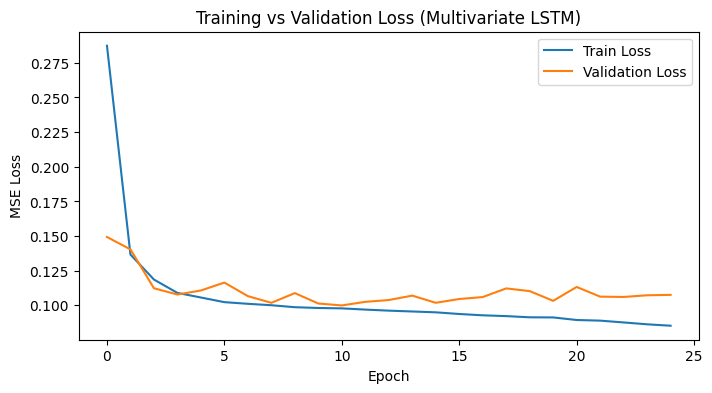

In [24]:
plt.figure(figsize=(8, 4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Training vs Validation Loss (Multivariate LSTM)")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()


In [25]:
uni_feature = ['temperature_2m_mean']

scaler_uni = StandardScaler()
scaler_uni.fit(train_df[uni_feature])

train_uni = scaler_uni.transform(train_df[uni_feature])
val_uni   = scaler_uni.transform(val_df[uni_feature])
test_uni  = scaler_uni.transform(test_df[uni_feature])

train_ds_uni = TimeSeriesDataset(train_uni, 0, WINDOW)
val_ds_uni   = TimeSeriesDataset(val_uni, 0, WINDOW)
test_ds_uni  = TimeSeriesDataset(test_uni, 0, WINDOW)

train_loader_uni = DataLoader(train_ds_uni, batch_size=BATCH_SIZE, shuffle=True)
val_loader_uni   = DataLoader(val_ds_uni, batch_size=BATCH_SIZE, shuffle=False)

model_uni = LSTMModel(input_dim=1)
train_model(model_uni, train_loader_uni, val_loader_uni)


Epoch 1: Train 0.3392, Val 0.1707
Epoch 2: Train 0.1642, Val 0.1334
Epoch 3: Train 0.1333, Val 0.1216
Epoch 4: Train 0.1199, Val 0.1161
Epoch 5: Train 0.1139, Val 0.1090
Epoch 6: Train 0.1111, Val 0.1065
Epoch 7: Train 0.1114, Val 0.1065
Epoch 8: Train 0.1108, Val 0.1071
Epoch 9: Train 0.1109, Val 0.1080
Epoch 10: Train 0.1100, Val 0.1093
Epoch 11: Train 0.1104, Val 0.1081
Epoch 12: Train 0.1107, Val 0.1118
Epoch 13: Train 0.1101, Val 0.1087
Epoch 14: Train 0.1093, Val 0.1116
Epoch 15: Train 0.1100, Val 0.1080
Epoch 16: Train 0.1093, Val 0.1147
Epoch 17: Train 0.1092, Val 0.1071
Epoch 18: Train 0.1095, Val 0.1108
Epoch 19: Train 0.1098, Val 0.1075
Epoch 20: Train 0.1102, Val 0.1077
Epoch 21: Train 0.1088, Val 0.1121
Epoch 22: Train 0.1104, Val 0.1087
Epoch 23: Train 0.1097, Val 0.1129
Epoch 24: Train 0.1092, Val 0.1082
Epoch 25: Train 0.1098, Val 0.1096


([0.3391712770852096,
  0.1641686002669089,
  0.1332551557022859,
  0.11990162431645919,
  0.11389693371294175,
  0.11107995385742363,
  0.11143727406092427,
  0.1107783639420043,
  0.11085451446364031,
  0.10999898248187759,
  0.11043433231465957,
  0.11074312496930361,
  0.11010117171441808,
  0.10927342842606937,
  0.11001169656896416,
  0.10929541013148777,
  0.10917313946137096,
  0.10953622598968007,
  0.10982575404512532,
  0.11018943657879443,
  0.10883484578088802,
  0.11038354200804058,
  0.10972038564710494,
  0.10919104206978399,
  0.10978659582050408],
 [0.17065890099514613,
  0.1334223554215648,
  0.1216012505306439,
  0.11611634238877079,
  0.10895305533300746,
  0.10646560212427919,
  0.1065296945585446,
  0.10712185349654067,
  0.10799707878719676,
  0.10926200026138262,
  0.1080733642659404,
  0.11177822981368411,
  0.10871419378302315,
  0.1116327392784032,
  0.10795744085176424,
  0.11473396877673539,
  0.10712405734441498,
  0.1108312892981551,
  0.1074996468695727

In [26]:
def evaluate(model, dataset):
    model.eval()
    preds, actuals = [], []
    with torch.no_grad():
        for X, y in dataset:
            X = X.unsqueeze(0).to(device)
            preds.append(model(X).item())
            actuals.append(y.item())
    return (
        np.sqrt(mean_squared_error(actuals, preds)),
        mean_absolute_error(actuals, preds)
    )

rmse_uni, mae_uni = evaluate(model_uni, test_ds_uni)
rmse_multi, mae_multi = evaluate(models["LSTM"], test_ds_temp)

final_results = pd.DataFrame({
    "Setup": ["Univariate LSTM", "Multivariate LSTM"],
    "RMSE": [rmse_uni, rmse_multi],
    "MAE": [mae_uni, mae_multi]
})

final_results


,Setup,RMSE,MAE
0,Univariate LSTM,0.348710,0.263980
1,Multivariate LSTM,0.340825,0.260643


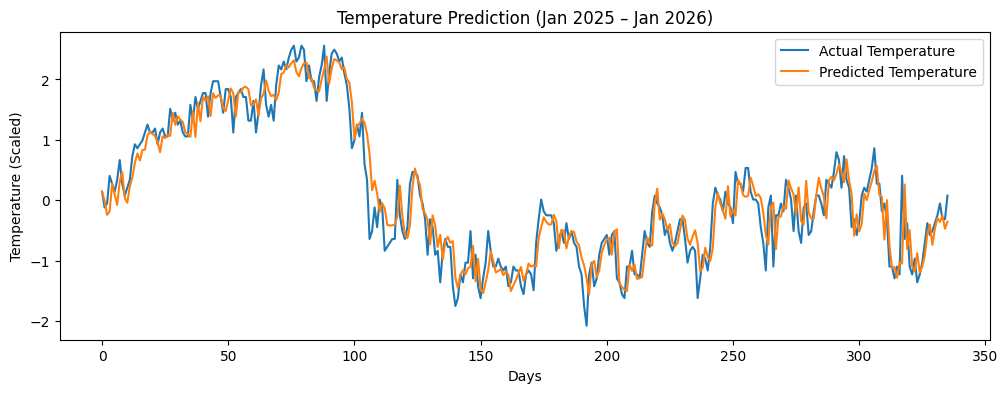

In [27]:
model_best = models["LSTM"]
model_best.eval()

temp_preds, temp_actuals = [], []

with torch.no_grad():
    for X, y in test_ds_temp:
        X = X.unsqueeze(0).to(device)
        temp_preds.append(model_best(X).item())
        temp_actuals.append(y.item())

plt.figure(figsize=(12, 4))
plt.plot(temp_actuals, label="Actual Temperature")
plt.plot(temp_preds, label="Predicted Temperature")
plt.title("Temperature Prediction (Jan 2025 – Jan 2026)")
plt.xlabel("Days")
plt.ylabel("Temperature (Scaled)")
plt.legend()
plt.show()


Epoch 1: Train 0.5064, Val 0.5431
Epoch 2: Train 0.4088, Val 0.5165
Epoch 3: Train 0.3995, Val 0.4992
Epoch 4: Train 0.3892, Val 0.4814
Epoch 5: Train 0.3891, Val 0.4794
Epoch 6: Train 0.3849, Val 0.4850
Epoch 7: Train 0.3776, Val 0.4823
Epoch 8: Train 0.3770, Val 0.4834
Epoch 9: Train 0.3716, Val 0.4872
Epoch 10: Train 0.3710, Val 0.4790
Epoch 11: Train 0.3684, Val 0.4831
Epoch 12: Train 0.3589, Val 0.5010
Epoch 13: Train 0.3564, Val 0.4861
Epoch 14: Train 0.3528, Val 0.4981
Epoch 15: Train 0.3516, Val 0.4814
Epoch 16: Train 0.3387, Val 0.4915
Epoch 17: Train 0.3382, Val 0.4980
Epoch 18: Train 0.3367, Val 0.4951
Epoch 19: Train 0.3321, Val 0.4953
Epoch 20: Train 0.3135, Val 0.5225
Epoch 21: Train 0.3008, Val 0.5282
Epoch 22: Train 0.2988, Val 0.5480
Epoch 23: Train 0.2860, Val 0.5372
Epoch 24: Train 0.2723, Val 0.5495
Epoch 25: Train 0.2664, Val 0.5600


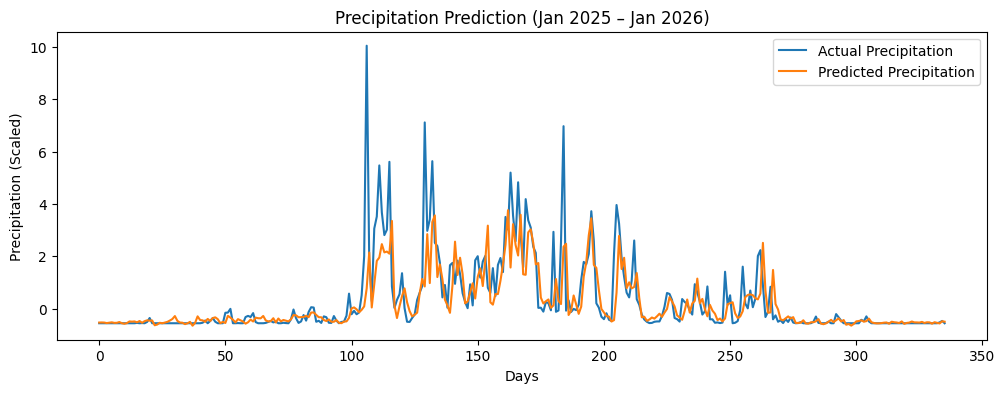

In [28]:
train_ds_prec = TimeSeriesDataset(train_scaled, prec_idx, WINDOW)
val_ds_prec   = TimeSeriesDataset(val_scaled, prec_idx, WINDOW)
test_ds_prec  = TimeSeriesDataset(test_scaled, prec_idx, WINDOW)

train_loader_prec = DataLoader(train_ds_prec, batch_size=BATCH_SIZE, shuffle=True)
val_loader_prec   = DataLoader(val_ds_prec, batch_size=BATCH_SIZE, shuffle=False)

model_prec = LSTMModel(len(features))
train_model(model_prec, train_loader_prec, val_loader_prec)

prec_preds, prec_actuals = [], []

with torch.no_grad():
    for X, y in test_ds_prec:
        X = X.unsqueeze(0).to(device)
        prec_preds.append(model_prec(X).item())
        prec_actuals.append(y.item())

plt.figure(figsize=(12, 4))
plt.plot(prec_actuals, label="Actual Precipitation")
plt.plot(prec_preds, label="Predicted Precipitation")
plt.title("Precipitation Prediction (Jan 2025 – Jan 2026)")
plt.xlabel("Days")
plt.ylabel("Precipitation (Scaled)")
plt.legend()
plt.show()
